In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, f1_score

print("✅ Libraries imported successfully.")

✅ Libraries imported successfully.



✅ Dataset loaded successfully.


/tmp/ipython-input-2889537850.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_emotions.values, y=top_emotions.index, palette='viridis')


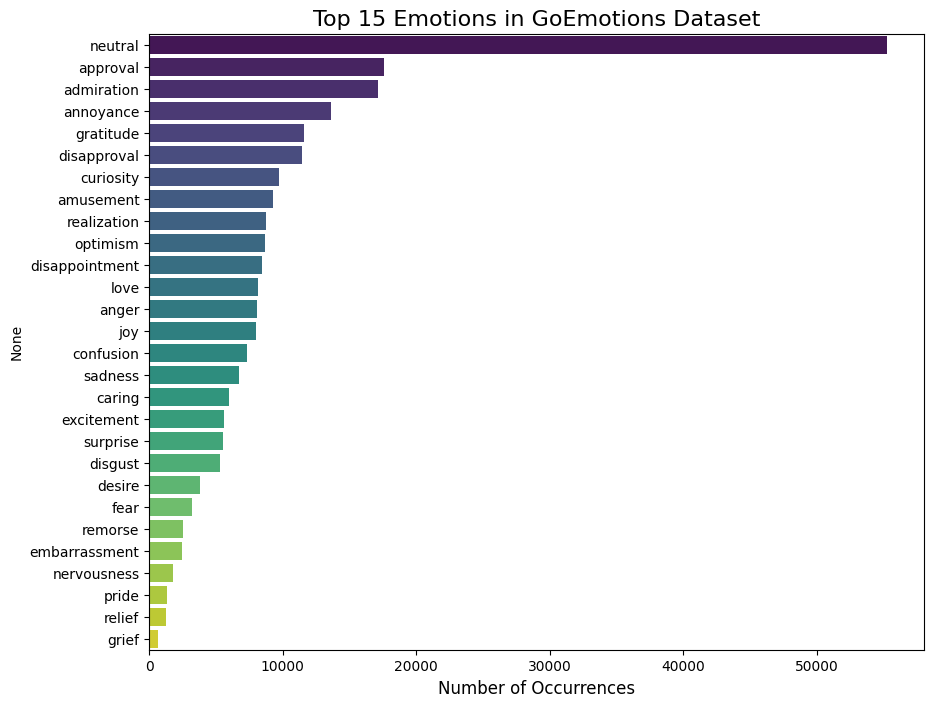

In [12]:
# --- 1. LOAD DATA AND EDA ---
try:
    df = pd.read_csv('GoEmotions.csv')
    print("\n✅ Dataset loaded successfully.")
except FileNotFoundError:
    print("❌ Error: GoEmotions.csv not found. Please upload the dataset.")
    exit()

# Define the list of emotion columns
emotion_cols = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion',
                'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment',
                'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism',
                'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']

# Quick EDA on all emotions
top_emotions = df[emotion_cols].sum().sort_values(ascending=False).head(28)
plt.figure(figsize=(10, 8))
sns.barplot(x=top_emotions.values, y=top_emotions.index, palette='viridis')
plt.title('Top 15 Emotions in GoEmotions Dataset', fontsize=16)
plt.xlabel('Number of Occurrences', fontsize=12)
plt.show()

In [13]:
# --- 2. DATA PREPARATION ---
# Create the 'labels' column
df['labels'] = df[emotion_cols].values.tolist()
df_model = df[['text', 'labels']].copy()

# Remove rows with missing labels
df_model.dropna(subset=['labels'], inplace=True)


# Use the same sample size for a fair comparison
df_sample = df_model.sample(n=50000, random_state=42)

# Split into training (80%) and testing (20%) sets
train_df, test_df = train_test_split(df_sample, test_size=0.2, random_state=42)

print("\n✅ Data prepared for modeling:")
print(f" - Training set size: {len(train_df)}")
print(f" - Test set size: {len(test_df)}")


✅ Data prepared for modeling:
 - Training set size: 40000
 - Test set size: 10000


In [14]:
# --- 3. FEATURE EXTRACTION AND MODEL TRAINING ---
# Convert text into numerical features using TF-IDF
# This looks at word frequency to determine importance.
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Learn the vocabulary from the training data and transform it
X_train = vectorizer.fit_transform(train_df['text'])

# Only transform the test data using the learned vocabulary
X_test = vectorizer.transform(test_df['text'])

# Convert the labels from a list of lists to a numpy array for scikit-learn
y_train = np.array(train_df['labels'].tolist())
y_test = np.array(test_df['labels'].tolist())

# We use OneVsRestClassifier because each text can have multiple emotions.
# It trains one classifier for each of our 28 emotions.
log_reg = LogisticRegression(solver='liblinear', random_state=42)
classifier = OneVsRestClassifier(log_reg)

print("\n🚀 Starting model training... (This will be much faster!)")
classifier.fit(X_train, y_train)
print("\n✅ Model training complete.")


🚀 Starting model training... (This will be much faster!)

✅ Model training complete.


In [15]:
# --- 4. EVALUATION ---
print("\n📊 Evaluating the model on the test set...")
y_pred = classifier.predict(X_test)

print("\nFinal Classification Report:")
# We use our list of emotion columns as the target names
print(classification_report(y_test, y_pred, target_names=emotion_cols, zero_division=0))



📊 Evaluating the model on the test set...

Final Classification Report:
                precision    recall  f1-score   support

    admiration       0.68      0.21      0.32       821
     amusement       0.58      0.25      0.35       447
         anger       0.59      0.05      0.09       405
     annoyance       0.25      0.01      0.01       671
      approval       0.64      0.02      0.04       804
        caring       0.60      0.01      0.02       269
     confusion       0.67      0.01      0.02       341
     curiosity       0.73      0.02      0.03       451
        desire       0.44      0.04      0.08       188
disappointment       0.00      0.00      0.00       423
   disapproval       0.25      0.01      0.01       563
       disgust       0.50      0.03      0.05       244
 embarrassment       0.50      0.02      0.03       112
    excitement       0.36      0.02      0.04       264
          fear       0.50      0.03      0.06       149
     gratitude       0.89     

In [16]:
# --- 5. USER PREDICTION FUNCTION ---
def predict_emotion_classic(text_input):
    """Takes a string and predicts emotions using the trained classic model."""
    print(f"\nAnalyzing your text: '{text_input}'")

    # Convert the single text input into a TF-IDF vector
    text_vector = vectorizer.transform([text_input])

    # Get the model's prediction (a list of 0s and 1s)
    prediction_vector = classifier.predict(text_vector)[0]

    # Find which emotions correspond to the '1's in the prediction
    predicted_emotions = [emotion_cols[i] for i, pred in enumerate(prediction_vector) if pred == 1]

    if not predicted_emotions:
        # If no emotion is predicted, we can find the most likely one using predict_proba
        probabilities = classifier.predict_proba(text_vector)[0]
        most_likely_index = probabilities.argmax()
        return [f"No strong emotion detected. Most likely: {emotion_cols[most_likely_index]}"]

    return predicted_emotions

In [17]:
# --- 6. EXAMPLE USAGE ---
print("\n\n✨ --- Test the Model with Your Own Input --- ✨")
my_text1 = "I just finished my final exam for the semester, what a relief!"
predicted_emotions1 = predict_emotion_classic(my_text1)
print(f"▶️ Predicted Emotions: {predicted_emotions1}")

my_text2 = "That movie was hilarious, my friend and I couldn't stop laughing."
predicted_emotions2 = predict_emotion_classic(my_text2)
print(f"▶️ Predicted Emotions: {predicted_emotions2}")

my_text3 = "I can't believe I missed the bus again... this is so annoying."
predicted_emotions3 = predict_emotion_classic(my_text3)
print(f"▶️ Predicted Emotions: {predicted_emotions3}")



✨ --- Test the Model with Your Own Input --- ✨

Analyzing your text: 'I just finished my final exam for the semester, what a relief!'
▶️ Predicted Emotions: ['No strong emotion detected. Most likely: neutral']

Analyzing your text: 'That movie was hilarious, my friend and I couldn't stop laughing.'
▶️ Predicted Emotions: ['amusement']

Analyzing your text: 'I can't believe I missed the bus again... this is so annoying.'
▶️ Predicted Emotions: ['No strong emotion detected. Most likely: annoyance']


###RandomForestClassifier


In [18]:
# --- 3. FEATURE EXTRACTION ---
# Initialize a TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit and transform the training data
X_train = vectorizer.fit_transform(train_df['text'])

# Transform the test data
X_test = vectorizer.transform(test_df['text'])

# Convert labels to numpy arrays
y_train = np.array(train_df['labels'].tolist())
y_test = np.array(test_df['labels'].tolist())

print("\n✅ Text data converted to numerical features using TF-IDF.")
print(f" - X_train shape: {X_train.shape}")
print(f" - X_test shape: {X_test.shape}")
print(f" - y_train shape: {y_train.shape}")
print(f" - y_test shape: {y_test.shape}")


✅ Text data converted to numerical features using TF-IDF.
 - X_train shape: (40000, 5000)
 - X_test shape: (10000, 5000)
 - y_train shape: (40000, 28)
 - y_test shape: (10000, 28)


In [19]:
# --- 4. TRAIN A RANDOM FOREST CLASSIFIER ---
# Instantiate the RandomForestClassifier
# We set n_estimators to a reasonable number to balance performance and speed.
# random_state ensures that the results are the same every time we run the code.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1) # Use all available cores

# Wrap with OneVsRestClassifier for multi-label classification
# This strategy trains one classifier for each of the 28 emotion labels.
classifier_rf = OneVsRestClassifier(rf_model)

# Train the model on the TF-IDF vectors
print("\n🚀 Starting RandomForestClassifier training... (This might take a few minutes)")
classifier_rf.fit(X_train, y_train)
print("\n✅ RandomForestClassifier training complete.")


🚀 Starting RandomForestClassifier training... (This might take a few minutes)

✅ RandomForestClassifier training complete.


In [20]:
# --- 5. EVALUATE THE RANDOM FOREST MODEL ---
# Predict emotions on the test set
y_pred_rf = classifier_rf.predict(X_test)

# Print the classification report
print("\nClassification Report for RandomForestClassifier:")
print(classification_report(y_test, y_pred_rf, target_names=emotion_cols, zero_division=0))



Classification Report for RandomForestClassifier:
                precision    recall  f1-score   support

    admiration       0.53      0.35      0.42       821
     amusement       0.50      0.42      0.46       447
         anger       0.30      0.15      0.20       405
     annoyance       0.21      0.09      0.12       671
      approval       0.25      0.12      0.16       804
        caring       0.23      0.09      0.13       269
     confusion       0.26      0.10      0.14       341
     curiosity       0.31      0.14      0.20       451
        desire       0.31      0.12      0.17       188
disappointment       0.22      0.08      0.12       423
   disapproval       0.25      0.11      0.15       563
       disgust       0.27      0.15      0.19       244
 embarrassment       0.23      0.12      0.16       112
    excitement       0.21      0.10      0.14       264
          fear       0.35      0.21      0.27       149
     gratitude       0.82      0.74      0.78       

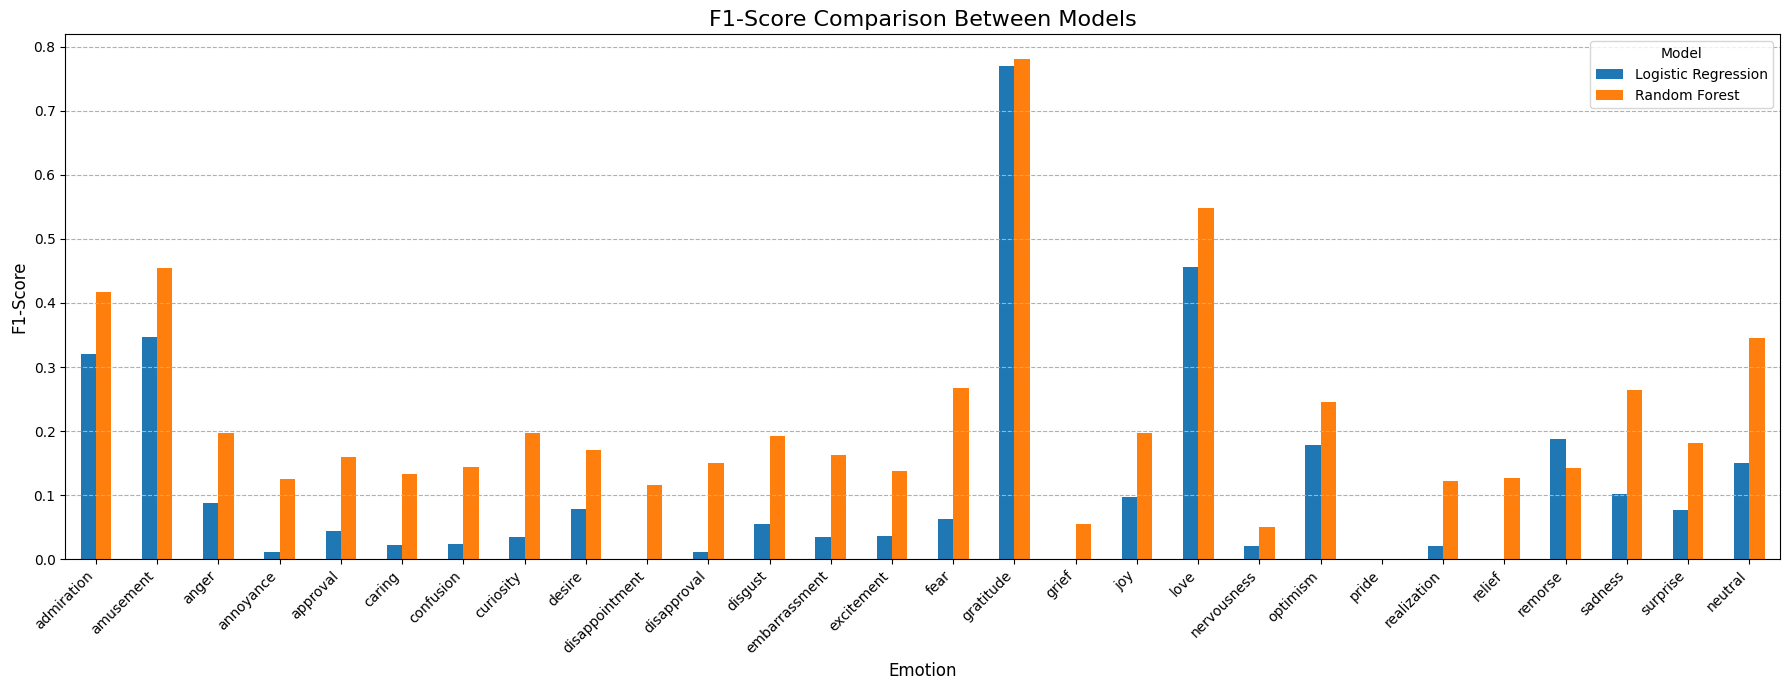

In [21]:
# --- 6. COMPARE MODELS ---
# Get the classification reports as dictionaries
report_log_reg = classification_report(y_test, y_pred, target_names=emotion_cols, output_dict=True, zero_division=0)
report_rf = classification_report(y_test, y_pred_rf, target_names=emotion_cols, output_dict=True, zero_division=0)

# Extract the F1-scores for each emotion
f1_scores_log_reg = {emotion: report_log_reg[emotion]['f1-score'] for emotion in emotion_cols}
f1_scores_rf = {emotion: report_rf[emotion]['f1-score'] for emotion in emotion_cols}

# Create a DataFrame for plotting
df_compare = pd.DataFrame({'Logistic Regression': f1_scores_log_reg, 'Random Forest': f1_scores_rf})

# Plot the comparison
df_compare.plot(kind='bar', figsize=(18, 7))
plt.title('F1-Score Comparison Between Models', fontsize=16)
plt.ylabel('F1-Score', fontsize=12)
plt.xlabel('Emotion', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()